# Causal Inference Project

# Evaluation of a Labor Market Training Program in Nonexperimental Studies

# Jiwon Son


# Abstract

This project compares different parametric estimators to estimate the treatment impact of the National Supported Work (NSW) Demonstration, a labor market training program, on postintervention earnings. This project then identifies which estimator among these nonexperimental methods gives the closest outcome to the experimental benchmark estimate.

This proejct uses data from Lalonde's evaluation of nonexperimental methods that combine the treated group from a randomized evaluation of the NSW with nonexperimental comparison group drawn from a survey dataset named Panel Study of Income Dynamics (PSID).

This project applies to the composite dataset a set of nonexperimental methods to obtain various estimates of treatment effect including: control function estimator, differences-in-differences, and propensity score stratification method. It turns out that propensity score estimates of the treatment impact approximate the experimental benchmark estimate the best.

This project concludes that when the variables determining assignment to treatment are observed, and when the treatment and comparison groups overlap, propensity score method provides by far the best means to estimate the treatment impact in a non-experimental setting.

*Key Words: Treatment Evaulation, Propensity Score Estimators, Stratification, Nonexperimental Studies


# Introduction and Motivation

This project discusses estimation of treatment effects in observational studies. Randomized experiments are relatively rare in the social sciences, and usually an observational sample is used with some individuals observed to receive a treatment while others do not. Previously Lalonde (1986) used data from a randomized evaluation of the NSW labor training program in 1976-77 and studied the extent to which nonexperimental estimators can replicate the "unbiased" experimental estimate of the treatment impact when applied to a composite dataset of experimental treatment units and nonexperimental comparison units. He concluded that standard nonexperimental estimators such as regression and fixed effect models are inaccurate. His work has ever since spurred efforts to search for an alternative estimator of treatment impact in nonexperimental studies.

First, I discuss nonexperimental estimates of treatment impact obtained from other estimators than propensity score methods and compare them to see how they differ in estimating treatment effect. Methods used here include 
treatment-control comparison, control function estimator, before-after comparison, and differences-in-differences estimator.

Next, I apply propensity score methods to Dehejia and Whaba's subset (with RE74 added) of Lalonde's dataset. Based on the idea of comparability of the treatment and nonexperimental comparison groups in terms of the preintervention variables, propensity score methods first assume that the variables associated with assignment to treatment are observed. Additionally, differences between the treatment and comparison groups must be controlled for when they are dissimilar and when there are many preintervention variables. The estimated propensity score can control for differences between the treatment and nonexperimental comparison groups. The estimated propensity score summarizes the preintervention variables and offers a diagnostic on the comparability of the treatment and comparison groups. When the range of estimated propensity scores of the treatment and comparison groups overlap, these methods can estimate the treatment impact for the treated group. In fact, when applying the propensity methods, I obtain the closest estimate to the unbiased experimental treatment effect than other nonexperimental estimates.


In [62]:
# Load core data science libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from causalinference import CausalModel
import scipy.stats as stats

# Load data
# Read the file and specify the column name/type, along with parameters


col_dtypes = {'Treat':int, 'Age':int, 'Education':int,\
              'Black':int, 'Hispanic':int, 'Married':int, 'Nodegree':int,\
              'RE74':float, 'RE75':float, 'RE78':float}

df_nswre74_t  = pd.read_csv('/Users/davidson/Downloads/nswre74_treated.txt',dtype=col_dtypes,\
                    na_values='', engine='c', sep = '\t',encoding = 'utf-8')

df_nswre74_c  = pd.read_csv('/Users/davidson/Downloads/nswre74_control.txt',dtype=col_dtypes,\
                    na_values='', engine='c', sep = '\t',encoding = 'utf-8')

df_psid_c  = pd.read_csv('/Users/davidson/Downloads/psid_controls.txt',dtype=col_dtypes,\
                    na_values='', engine='c', sep = '\t',encoding = 'utf-8')


#Source: "Causal Effects in Non-Experimental Studies: Reevaluating the Evaluation of Training Programs," Journal of the American Statistical Association, Vol. 94, No. 448 (December 1999), pp. 1053-1062. 
#        "Propensity Score Matching Methods for Non-Experimental Causal Studies," Review of Economics and Statistics, Vol. 84, (February 2002), pp. 151-161.
#         The data are drawn from a paper by Robert Lalonde, "Evaluating the Econometric Evaluations of Training Programs," American Economic Review, Vol. 76, pp. 604-620.

# Data

This project draws upon the RE74 subset (of NSW treated) data and PSID comparison group data as part of replication of Dehejia and Whaba (1999) study.

RE74 subset originally comes from Lalonde's research on the impact of the NSW. The demonstration at that time looked at the male participants in the program for 1976-77 period, using 1975 as the preintervention earnings and 1978 as the postintervention earnings. Dehija and Wahba (1999) recognize the importance of looking at more than one year of preintervention earnings in determining the effect of job training programs and further limit their study to the subset of Lalonde's NSW data for which 1974 earnings can be obtained.

Non-experimental comparison group PSID is obtained from the Panel Study of Income Dynamics (PSID-1), as used in Lalonde (1999).

Overall, in the composite data, the treated RE74 subset consists of the 185 males who received training during 1976-1977. The comparison group is one of the 2490 male household heads under the age of 55 who are not retired, drawn from the PSID.


In [63]:
# Summary Table for Treatment (RE74 subset) and Comparison (PSID-1) Group

print(df_nswre74_t.describe())
print(df_psid_c.describe())

# T-test for mean difference

stats.ttest_ind(df_nswre74_t.drop(['Treat'], axis=1), df_psid_c.drop(['Treat'], axis=1), equal_var = False)

       Treat         Age   Education       Black    Hispanic     Married  \
count  185.0  185.000000  185.000000  185.000000  185.000000  185.000000   
mean     1.0   25.816216   10.345946    0.843243    0.059459    0.189189   
std      0.0    7.155019    2.010650    0.364558    0.237124    0.392722   
min      1.0   17.000000    4.000000    0.000000    0.000000    0.000000   
25%      1.0   20.000000    9.000000    1.000000    0.000000    0.000000   
50%      1.0   25.000000   11.000000    1.000000    0.000000    0.000000   
75%      1.0   29.000000   12.000000    1.000000    0.000000    0.000000   
max      1.0   48.000000   16.000000    1.000000    1.000000    1.000000   

         Nodegree          RE74          RE75          RE78  
count  185.000000    185.000000    185.000000    185.000000  
mean     0.708108   2095.767568   1531.417838   6348.908108  
std      0.455867   4885.554103   3216.415954   7866.648942  
min      0.000000      0.000000      0.000000      0.000000  
25%  

Ttest_indResult(statistic=array([-15.9581066 , -11.05351659,  21.03410202,   1.51350687,
       -22.82134259,  11.58928295, -38.64650253, -48.58605649, -23.14116753]), pvalue=array([  7.51578401e-040,   1.94533387e-023,   5.43253494e-055,
         1.31732745e-001,   3.37581692e-058,   2.13287086e-024,
         4.03197092e-143,   1.23800564e-251,   4.56105356e-069]))

Summary Statistics of the RE74 subsample (of nsw treated) and the PSID sample (comparison group)

It is clear that the PSID differs considerably from the RE74 subsample in terms of age, education, ethnicity, marital status, and preintervention earnings. Specifically, the treatment group is disproportionately black (84%) with less than a high school degree (71%). In fact, all of the mean differences are significantly different from 0 beyond a 1% level of significance, except for the indicator for "Hispanic."

Under this situation, estimates of the effect of training should control for these differences. For example, we might want to use propensity score stratfication to obtain ATET given that the unconfoundedness and overlap assumptions hold.

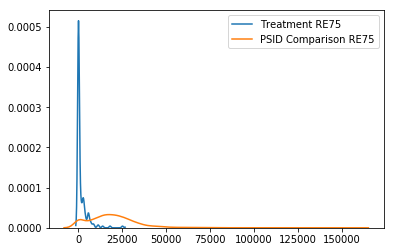

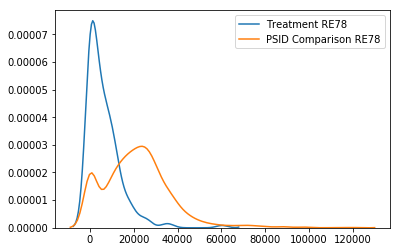

In [64]:
# Concatenated dataframe of unmatched treatment and control groups--composite dataset for propensity method

unmatched_raw = pd.concat([df_psid_c, df_nswre74_t], axis=0)

#Comparison between Control and Treatment groups Before and After Training--Real Earnings in 1975 vs. 1978

sns.kdeplot(unmatched_raw[unmatched_raw.Treat == 1].RE75, label='Treatment RE75')
sns.kdeplot(unmatched_raw[unmatched_raw.Treat == 0].RE75, label='PSID Comparison RE75');
plt.show()

sns.kdeplot(unmatched_raw[unmatched_raw.Treat == 1].RE78, label='Treatment RE78')
sns.kdeplot(unmatched_raw[unmatched_raw.Treat == 0].RE78, label='PSID Comparison RE78');
plt.show()

As shown on the graphs above, treatment and comparison groups have different distributions of real earnings in 1975 and 1978. The comparison group earns more than the treatment group in both years. Apparently, the treatment group shows improvement in earnigs after the treatment since the earnings gap narrows in 1978.

# Identification of Average Treatment Effect


Various approaches can be used to estimate the effect of training on earnings.

The first approach used here is control function approach, where we look at the coefficient $\alpha$ of the treatment indicator $D_{i}$ in OLS regression of $RE78_{i}$ on an intercept and $D_{i}$ in a combined treatment-control sample, with the regression as shown below:

$RE78_{i} = x_{i}^{'} \beta + \alpha D_{i} + u_{i},    i = 1,...,2675$

The second approach is difference-in-differences, where before-after comparison first looks at the difference between posttreatment earnings RE78 and pretreatment earnings RE75. Then, difference-in-differences estimator is obtained in a regression as shwon below:

$RE78_{it} = \phi + \delta D78_{it} + \gamma D_{i} + \alpha D78_{it}D_{i} + u_{i}, i = 1,...,2675,   t = 75, 78$,

where $D78_{it}$ is a treatment variable of $i$ in $t$, and $\alpha$ is the estimate of treatment impact.

Now, to validate estimating ATET using propensity score methods, let $RE78_{i1}$ represent the value of treatment earning $i$ in $1978$, and $RE78_{i0}$ the value of comparison earning as in the two regressions above. Then since only one of them can be observed for any unit, the observed outcome for unit $i$ is $RE78_{i} = D_{i}RE78_{i1}+(1-D_{i})RE78_{i0}$. The treatment effect for unit $i$ is $\tau_{i} = RE78_{i1}-RE78_{i0}$.

In an experimental setting with randomized assignment to treatment, the treatment and control groups are drawn from the same population. The average treatment effect for this population is $\tau = E(RE78_{i1}) - E(RE78_{i0})$. Randomization implies that ${RE78_{i0}, RE78_{i1}} \!\perp\!\!\!\perp D_{i}$,

so $\tau = E(RE78_{i1}|D_{i}=1)-E(RE78_{i0}|D_{i}=0) = E(RE78_{i}|D_{i}=1)-E(RE78_{i}|D_{i}=0)$,

which is easily estimated.

In an observational study, the treatment and comparison groups are often drawn from different populations. Here the treatment group is drawn from population of interest: NSW welfare recipients. Nonexperimental comparison group is drawn from a different population, and thus more representative of the general population. The treatment effect that we are trying to identify is the ATET (average treatment effect for the treated population):

$\tau|_{D=1} = E(RE78_{i1}|D_{i}=1) - E(RE78_{i0}|D_{i}=1)$.
                            
This expression cannot be estimated directly, because $RE78_{i0}$ is not observed for treated units. Assuming ${RE78_{i1},RE78_{i0} \!\perp\!\!\!\perp D_{i}}|X_{i}$, we obtain 

$E(RE78_{ij}|X_{i},D_{i}=1) = E(RE78_{ij}|X_{i},D_{i}=0) = E(RE78_{i}|X_{i},D_{i}=j)$ for $j = 0,1$. 

To restate in words, this is to say that conditional on the observables, $X_{i}$, there is no systematic pretreatment difference between the groups assgiend to treatment and control. This allows us to identify the ATET as in the following:

$\tau|_{D=1} = E(E(RE78_{i}|D_{i}=1,X_{i})-E(RE78_{i}|D_{i}=0,X_{i})|D_{i}=1)$.
            
Now, propensity score $p(X_{i})$ is defined as in the following: $p(X_{i}) = Pr(D_{i} = 1|X_{i}) = E(D_{i}|X_{i})$.

Asssuming that $0< p(X_{i}) < 1$, for all $X_{i}$ and $Pr(D_{1}, D_{2},..., D_{N}|X_{1},X_{2},...,X_{N}) = \Pi_{i=1,2,...,N}p(X_{i})^{D_{i}}(1-p(X_{i}))^{(1-D_{i})}$ for the N units in the sample,

${RE78_{i0}, RE78_{i1}} \!\perp\!\!\!\perp D_{i}|X_{i} =implies= {RE78_{i0}, RE78_{i1}} \!\perp\!\!\!\perp D_{i}|p(X_{i})$.

Then $\tau|_{D=1} = E[[E(RE78_{i}|D_{i}=1,p(X_{i})) - E(RE78_{i}|D_{i}=0,p(X_{i}))]|D_{i}=1]$,

giving the same result when conditioning on $p(X_{i})$, since observations with the same propensity score would have the same distribution of $X_{i}$.


# Estimation Strategy

First, I use treatment-control comparison and measure the effect of training by direct comparison of sample means of posttreatment earnings for the combined treatment and comparison groups. Next, I adopt a control function estimator, adding and thus controlling for the covariates. Then, I use before-after comparison and look at the difference between posttreatment and pretreatment earnings. Considering that the estimate could be misleading from reflecting all changes over this time period, I use the difference-in-differences estimator.

Then I turn to the propensity score estimator. I estimate the propensity score for the composite sample consisting of the treatment units and the comparison units. I use a logistic probability model, under the assumption of $X_{i} \!\perp\!\!\!\perp D_{i}|p(X_{i})$:
Conditional on the propensity score, the covariates are independent of assignment to treatment, and each individual has the same probability of assignment to treatment, as in a randomized experiment.

I stratify observations based on the estimated propensity score and balance the covariates within each stratum. Next, given the estimated propensity score, I estimate a univariate nonparametric regression. With stratification, observations are sorted from lowest to highest estimated propensity score. The strata, defined on the estimated propensity score, are chosen so that the covariates within each stratum are balanced across the treatment and comparison units. The process of validating the propensity score estimate produces partition structures that balance preintervention covariates across the treatment and comparison groups within each stratum.

In [65]:
#########################

#Least Squares Regression of RE78 onto a constant, a Treatment indicator, Age, Age^2,
#Education, Nodegree, Black, Hispanic, RE74, and RE75

df_nswre74_t['constant'] = 1
df_nswre74_c['constant'] = 1
df_psid_c['constant'] = 1

df_nswre74_t['Age2'] = df_nswre74_t['Age']^2
df_nswre74_c['Age2'] = df_nswre74_c['Age']^2
df_psid_c['Age2'] = df_psid_c['Age']^2


Y_nswre74_t = df_nswre74_t['RE78']
Y_nswre74_c = df_nswre74_c['RE78']
X_nswre74_t = df_nswre74_t[['constant','Treat','Age','Age2','Education','Nodegree',\
                  'Black','Hispanic','RE74','RE75']]
X_nswre74_c = df_nswre74_c[['constant','Treat','Age','Age2','Education','Nodegree',\
                  'Black','Hispanic','RE74','RE75']]
X_psid_c = df_psid_c[['constant','Treat','Age','Age2','Education','Nodegree',\
                  'Black','Hispanic','RE74','RE75']]

##########################

#control function estimator for experimental control/treatment data ==> experimental/benchmark estimates
#use RE74 subsample given in Dehejia and Whaba(1999) instead of Lalonde(1986)

df_nswre74_combined = pd.concat([df_nswre74_t,df_nswre74_c],axis=0)

Y_nswre74_combined = df_nswre74_combined['RE78']
X_nswre74_combined = df_nswre74_combined[['constant','Treat','Age','Age2','Education','Nodegree',\
                  'Black','Hispanic','RE74','RE75']]

ols = sm.OLS(Y_nswre74_combined,X_nswre74_combined).fit()
print(ols.summary())

##########################


                            OLS Regression Results                            
Dep. Variable:                   RE78   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     2.847
Date:                Wed, 09 May 2018   Prob (F-statistic):            0.00287
Time:                        11:28:47   Log-Likelihood:                -4534.0
No. Observations:                 445   AIC:                             9088.
Df Residuals:                     435   BIC:                             9129.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     797.2273   3352.885      0.238      0.8

According to Lalonde, the NSW program assigned qualified applicants to training positions randomly, whereby those assigned to the treatment group received all the benefits of the NSW program, while those assigned to the control group were left on their own. The OLS result above thus gives an experimental estimate of the treatment impact on the earnings, as shown in the coefficient of the Treat. This is the benchmark estimate that can be compared with other estimates, which I gain through nonexperimental methods.

In [66]:
#Training Impact: Various Estimates of Treatment Effect

############################

#The mean difference in RE78 between NSW treated and PSID control individuals
#(treatment-control comparision estimator--mimics the analysis in an experimental setting)

ATE = np.mean(df_nswre74_t['RE78'])-np.mean(df_psid_c['RE78'])
print(ATE)

############################

df_psid_combined = pd.concat([df_nswre74_t,df_psid_c],axis=0)

RE78 = df_psid_combined['RE78']
D = df_psid_combined[['Treat','constant']]

ols = sm.OLS(RE78,D).fit()

print(ols.summary())

#############################

-15204.145988277432
                            OLS Regression Results                            
Dep. Variable:                   RE78   R-squared:                       0.061
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     173.4
Date:                Wed, 09 May 2018   Prob (F-statistic):           2.02e-38
Time:                        11:28:47   Log-Likelihood:                -29544.
No. Observations:                2675   AIC:                         5.909e+04
Df Residuals:                    2673   BIC:                         5.910e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Treat       -1.52e+04   1154.533

When we simply take the mean difference in RE78 between NSW treated and PSID control units, or equivalently when we run OLS Regression of Posttreatment earning on a constant and the treatment variable, then we obtain a negative treatment impact estimate of -15204.

In [67]:
#############################

#control function estimator
RE78 = df_psid_combined['RE78']
D2 = df_psid_combined.drop(['RE78'],axis=1)
D2 = D2.drop(['Married'],axis=1)

ols_cf = sm.OLS(RE78,D2).fit()

print(ols_cf.summary())

#############################

                            OLS Regression Results                            
Dep. Variable:                   RE78   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     418.7
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        11:28:48   Log-Likelihood:                -28449.
No. Observations:                2675   AIC:                         5.692e+04
Df Residuals:                    2665   BIC:                         5.698e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Treat        105.3498    863.319      0.122      0.9

When we use control function estimator, the estimate of the treatment impact is 105. Adding control variables to the regression thus gives a positive estimate of the treatment impact.

In [68]:
#############################

#Before-after comparison

BATE = np.mean(df_nswre74_t['RE78'])-np.mean(df_nswre74_t['RE75'])
print(BATE)

#############################

4817.490270270271


Before-after comparison of the treatment gives an estimate of the treatment impact equal to 4817, quite large compared to the benchmark estimate.

In [69]:
#############################

#Difference-in-differences (DiD)
BATE = np.mean(df_nswre74_t['RE78'])-np.mean(df_nswre74_t['RE75'])
BAC = np.mean(df_psid_c['RE78'])-np.mean(df_psid_c['RE75'])

DiD = BATE-BAC
print(DiD)

#############################
#DID OLS regression
#df_combined = df_combined.reindex()

df_psid_combined['D78_0'] = 0
df_psid_combined['D78_1'] = 1

X_i = pd.concat([D2,D2],axis=0)

RE78_it = pd.concat([df_psid_combined['RE75'],df_psid_combined['RE78']],axis=0)
X_i['RE78_it'] = np.array(RE78_it)

D78_it = pd.concat([df_psid_combined['D78_0'],df_psid_combined['D78_1']],axis=0)
X_i['D78_it'] = np.array(D78_it)

#X_i = X_i.reindex()

X_i['D78_itD_i'] = X_i['D78_it']*X_i['Treat']

X_DiD = X_i.drop(['RE78_it'],axis=1)

ols_DiD = sm.OLS(X_i['RE78_it'],X_DiD).fit()
print(ols_DiD.summary())
#############################

2327.5993064148497
                            OLS Regression Results                            
Dep. Variable:                RE78_it   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     1501.
Date:                Wed, 09 May 2018   Prob (F-statistic):               0.00
Time:                        11:28:48   Log-Likelihood:                -55208.
No. Observations:                5350   AIC:                         1.104e+05
Df Residuals:                    5338   BIC:                         1.105e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Treat      -1111.1247    595.267 

The Difference-in-Differences estimator gives 2327 as an estimate of the treatment impact (coefficient on D78_itD_i), closer to the benchmark estimate of 1674 than the estimate obtained by before-after comparison.

Optimization terminated successfully.
         Current function value: 0.660176
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  Treat   No. Observations:                  445
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                            8
Date:                Wed, 09 May 2018   Pseudo R-squ.:                 0.02755
Time:                        11:28:48   Log-Likelihood:                -293.78
converged:                       True   LL-Null:                       -302.10
                                        LLR p-value:                   0.03404
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.1112      1.049      1.059      0.290      -0.945       3.167
Age            0.0113      0.

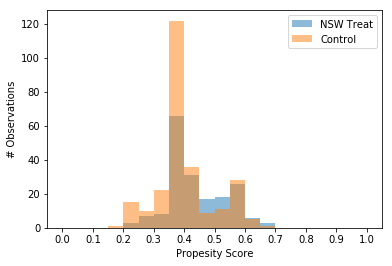

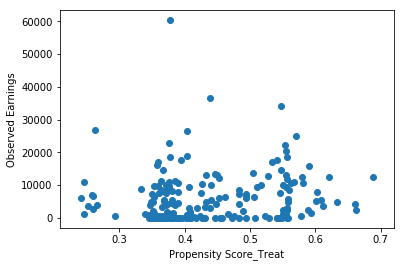

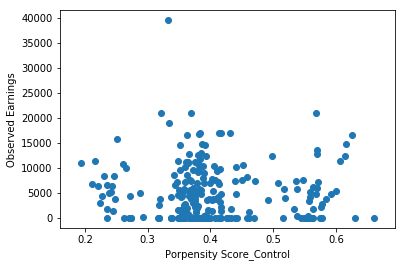

In [70]:
# Propensity Score e(x) for Experimental Estimates
# Logit  or  log odds ratio ==> log[ e(x) / ( 1 - e(x) ) ] 
# e(x)  =  exp(logit) / ( 1 + exp(logit) )


df_nswre74 = pd.concat([df_nswre74_t,df_nswre74_c],axis=0)
X_nswre74 = pd.concat([X_nswre74_t,X_nswre74_c],axis=0)

# Construct the outcome vector for logistic regression 
Y_nswre74_logit = df_nswre74['Treat']


# Construct the design matrix for the logistic regression
# We only need to remove the "Treat" column from the previous design matrix
X_nswre74_logit = X_nswre74.drop(['Treat'],axis=1)

# Compute the logistic regression
logit = sm.Logit(Y_nswre74_logit,X_nswre74_logit).fit()

print(logit.summary())


# Compute the fitted propensity scores and append it to the dataframe
df_nswre74['propensity_score'] = logit.predict()


############################

# Extract the propensity scores correspoinding to SAT==1
ps_t = np.array(df_nswre74['propensity_score'][df_nswre74['Treat']==1])

# Extract the propensity scores corresponding to SAT==0
ps_c = np.array(df_nswre74['propensity_score'][df_nswre74['Treat']==0])

# Set the intervals (bins) for propensity scores
bins = np.linspace(0,1,21)

# Plot the histogram corresponding to SAT==1, with 20 bins. label it SAT
plt.hist(ps_t,bins, alpha = 0.5, label = 'NSW Treat')

# Plot (overlay) the histogram for SAT==0 with 20 bins. label it CEB
plt.hist(ps_c,bins, alpha = 0.5, label = 'Control')
plt.legend()

# Label the X and Y axes
plt.xlabel('Propesity Score')
plt.ylabel('# Observations')

# Set ticks on the x-axis
plt.xticks(np.linspace(0,1,11))

plt.show()

############################

plt.scatter(ps_t, df_nswre74_t['RE78'])

plt.xlabel('Propensity Score_Treat')
plt.ylabel('Observed Earnings')

plt.show()

plt.scatter(ps_c, df_nswre74_c['RE78'])

plt.xlabel('Porpensity Score_Control')
plt.ylabel('Observed Earnings')

plt.show()

#############################


The above is a plot of the two histograms, with 20 bins, for the estimated propensity scores. The blue-colored bars correspond to the NSW program treatment group, and the apricot colored ones correspond to the control group. The brown colors indicate the overlap.

The histograms show that the overlap condition is overall well satisfied. The obsesrvations are concentrated in the center([0.2,0.7]),and there isn't any huge discrepancy to speak of in any bin.

Optimization terminated successfully.
         Current function value: 0.094816
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  Treat   No. Observations:                 2675
Model:                          Logit   Df Residuals:                     2666
Method:                           MLE   Df Model:                            8
Date:                Wed, 09 May 2018   Pseudo R-squ.:                  0.6229
Time:                        11:28:48   Log-Likelihood:                -253.63
converged:                       True   LL-Null:                       -672.65
                                        LLR p-value:                1.303e-175
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.2152      1.134      1.072      0.284      -1.007       3.437
Age           -0.1291      0

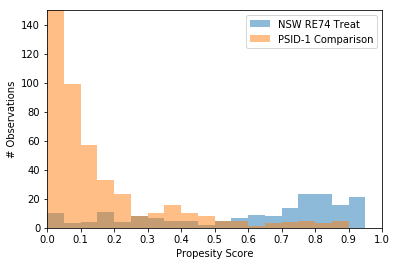

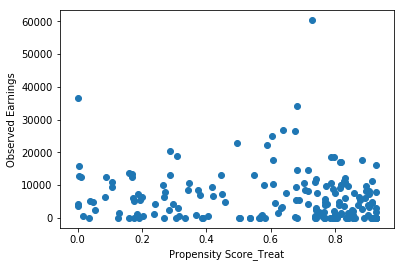

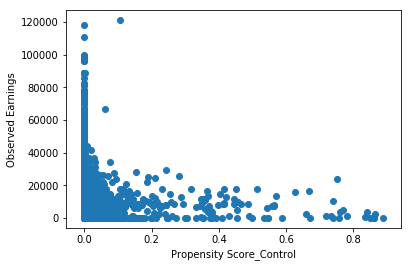

In [71]:
# Propensity Score e(x) for Non-Experimental Estimates

# Propensity Score_psid_c = e(x)

# logit ( or log odds ratio = (log e(x)/(1-e(x)) )

df_dw = pd.concat([df_nswre74_t,df_psid_c],axis=0)
X_dw = pd.concat([X_nswre74_t,X_psid_c],axis=0)

# Construct the outcome vector for logistic regression 
Y_dw_logit = df_dw['Treat']

# Construct the design matrix for the logistic regression
# We only need to remove the "Treat" column from the previous design matrix
X_dw_logit = X_dw.drop(['Treat'],axis=1)

# Compute the logistic regression
logit = sm.Logit(Y_dw_logit,X_dw_logit).fit()

print(logit.summary())

# Compute the fitted propensity scores and append it to the dataframe
df_dw['propensity_score'] = logit.predict()

############################

# Extract the propensity scores correspoinding to Treat==1
ps_dw_t = np.array(df_dw['propensity_score'][df_dw['Treat']==1])

# Extract the propensity scores corresponding to Treat==0
ps_dw_c = np.array(df_dw['propensity_score'][df_dw['Treat']==0])

# Set the intervals (bins) for propensity scores
bins = np.linspace(0,1,21)

# Plot the histogram corresponding to Treat==1, with 20 bins. label it
plt.hist(ps_dw_t,bins, alpha = 0.5, label = 'NSW RE74 Treat')

# Plot (overlay) the histogram for Treat==0 with 20 bins. label it
plt.hist(ps_dw_c,bins, alpha = 0.5, label = 'PSID-1 Comparison')
plt.legend()

# Label the X and Y axes
plt.xlabel('Propesity Score')
plt.ylabel('# Observations')

# Set ticks on the x-axis
plt.xticks(np.linspace(0,1,11))
plt.axis([0,1,0,150])
plt.show()

#############################

plt.scatter(ps_dw_t, df_nswre74_t['RE78'])
plt.xlabel('Propensity Score_Treat')
plt.ylabel('Observed Earnings')
plt.show()

plt.scatter(ps_dw_c, df_psid_c['RE78'])
plt.xlabel('Propensity Score_Control')
plt.ylabel('Observed Earnings')
plt.show()

The above is a plot of two histograms, with 20 bins, for the estimated propensity scores. The blue-colored bars correspond to the NSW program treatment group, and the apricot colored ones correspond to the PSID comparison group. The brown colors indicate the overlap.
The histograms show that the overlap condition is meagerly satisfied. First, there are no observations at the right-hand side ([0.95,1]) and a huge discrepancy at the left-hand side. We may disregard these intervals because there are no observations from both groups. The above plot indicates that there is an interval, [0.9,0.95], where we do not have overlap.

Here, to estimate average treatment effect we have to implement subclassification. Imbens (2015) stresses the importance of dropping units with extreme values of th propensity score to obtain a more balanced sample, which I do through the trimming process after estimating the propensity scores through causal_model function. It is shown and printed in the causal model summary statistics below.

In [72]:
#Quadratic in score_PSID

Y_dw = df_dw['RE78']
df_dw['propensity_score2'] = df_dw['propensity_score']**2
X_dw = df_dw[['constant','Treat','propensity_score2']]

ols = sm.OLS(Y_dw,X_dw).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   RE78   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     108.0
Date:                Wed, 09 May 2018   Prob (F-statistic):           7.79e-46
Time:                        11:28:49   Log-Likelihood:                -29524.
No. Observations:                2675   AIC:                         5.905e+04
Df Residuals:                    2672   BIC:                         5.907e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
constant           2.176e+04    303.12

In the regression of RE78 on quadratic propensity scores, the estimator of treatment impact is -7086, again negative.

In [73]:
# Concatenated dataframe of unmatched treatment and control groups--composite dataset for propensity method

unmatched_raw = pd.concat([df_psid_c, df_nswre74_t], axis=0)

unmatched_raw['u74'] = (unmatched_raw.RE74 == 0).astype(np.int32)
unmatched_raw['u75'] = (unmatched_raw.RE75 == 0).astype(np.int32)

# Causal Effect of the Training Program
# Average Treatment Effect on the Treated (Regression on the overlap population)
# Propensity Score Block/Stratification Matching
# Stratification-stratifying the sample into blocks that contain units with similar propensity scores.
# ATET is the weighted average of the differences between the average outcome of the treated and the control groups in strata.

causal_model = CausalModel(
    X=unmatched_raw[['Age', 'Education', 'Black', 'Hispanic', 'Married', 'Nodegree', 'RE74', 'RE75', 'u74', 'u75']].values, 
    D=unmatched_raw.Treat.values,
    Y=unmatched_raw.RE78.values
)

#Estimates the propensity scores given list of covariates to include linearly or quadratically.
#The propensity score is the conditional probability of receiving the treatment given the observed covariates. Estimation is done via a logistic regression.

causal_model.est_propensity()

#Trims data based on propensity score to create a subsample with better covariate balance.
#The default cutoff value is set to 0.1. This method should only be executed after the propensity score has been estimated.
#Trims data based on propensity score using the cutoff selection algorithm suggested by Reference1.
#Reference1: Crump, R., Hotz, V., Imbens, G., & Mitnik, O. (2009). Dealing with Limited Overlap in Estimation of Average Treatment Effects. Biometrika, 96, 187-199.

causal_model.trim_s()

#Stratifies the sample based on propensity score using the bin selection procedure suggested by Reference2.
#The bin selection algorithm is based on a sequence of two-sample t tests performed on the log-odds ratio.
#Reference2: Imbens, G. & Rubin, D. (2015). Causal Inference in Statistics, Social, and Biomedical Sciences: An Introduction.

causal_model.stratify_s()


#Estimates average treatment effects using least squares
causal_model.est_via_ols()


#Estimates average treatment effects using nearest-neighborhood matching
causal_model.est_via_matching(weights='inv', matches=1, bias_adj=True)


print(causal_model.summary_stats)
print(causal_model.estimates)
print(causal_model.propensity)
print(causal_model.strata)
print('blocks:   ', causal_model.blocks)


Summary Statistics

                       Controls (N_c=164)         Treated (N_t=124)             
       Variable         Mean         S.d.         Mean         S.d.     Raw-diff
--------------------------------------------------------------------------------
              Y     7088.268    11357.235     6176.347     6847.842     -911.922

                       Controls (N_c=164)         Treated (N_t=124)             
       Variable         Mean         S.d.         Mean         S.d.     Nor-diff
--------------------------------------------------------------------------------
             X0       29.634       10.726       27.476        7.473       -0.233
             X1       10.500        2.998       10.524        2.078        0.009
             X2        0.732        0.444        0.806        0.397        0.177
             X3        0.061        0.240        0.073        0.260        0.046
             X4        0.512        0.501        0.210        0.409       -0.661
      

In the NSW treatment earings less comparison group earnings, conditional on the stratified propensity score, the estimated treatment impact is 1222, closer to the benchmark estimate than other nonexperimental estimates. On the other hand, treatment impact obtained from nearest neighborhood matching is 3119, still higher than the benchmark.

In [74]:
#Results in Table
#Training Impact: Various Estimates of Treatment Effect
#############################
 
Method = ["Method", "*Benchmark", "Treatment-control comparison", "Control function estimator", "Before-after comparison", "Differences-in-differences", "Quadratic propensity score", "*Propensity score stratification"]
Estimate = ["Estimate", 1674, -15204, 105, 4817, 2327, -7086, 1222]
StdError = ["StdError", 638, 1154, 863, "", 791, 1720, 1227]

df = pd.DataFrame([Method, Estimate, StdError])
df.T

#############################

,0,1,2
0,Method,Estimate,StdError
1,*Benchmark,1674,638
2,Treatment-control comparison,-15204,1154
3,Control function estimator,105,863
4,Before-after comparison,4817,
5,Differences-in-differences,2327,791
6,Quadratic propensity score,-7086,1720
7,*Propensity score stratification,1222,1227


# Conclusions

This project has studied how to estimate the treatment impact in an observational study using a set of nonexperimental estimators. Specifically, this project relies on the propensity stratification method to estimate the treatment impact of National Supported Work Program on posttraining earnings. Unconfoundedness assumption guarantees that stratifying on propensity scores provides a valid way of constructing treatment effect estimators.

Results show that the propensity score estimate of the training effect for Dehejia and Whaba's composite dataset is good relative to other estimators. Using this method, I obtain estimates of the treatment impact of 1222, close to the benchmark estimate of 1674, unbiased and gained from experiment.

The methods suggested are certainly not relevant in all situations. There may be important yet unobserved covariates, for which the propensity score method cannot account. Still, there is reward in exploring the information contained in the observed variables in and of itself. All in all, propensity score methods can offer both a diagnositc on the quality of the comparison group and a means to estimate the treatment impact. For further work, it might be useful to consider additional lagged measures of earnnigs to get a better assessment of the unconfoundedness assumption.

# References

Dehejia, R., and Whaba, S. (1999), "Causal Effects in Nonexperimental Studies: Reevaluating the Evaulation of Training Programs."

Lalonde, R. (1986), "Evaluating the Econometric Evaluations of Training Programs," American Economic Review, 76, pp. 604-620.

Imbens, G. (2015), "Matching Methods in Practice: Three Examples," Journal of Human Resources, University of Wisconsin Press, vol. 50(2), pp. 373-419.

Cameron, A.C. and P.K. Trivedi (2005), Microeconometrics: methods and applications, Cambridge, pp. 889–95